In [2]:
# -*- coding: utf-8 -*-

import netCDF4 as nc4
import numpy as np
import time, sys, os


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FixedLocator, FixedFormatter,
                               NullLocator)
import matplotlib.gridspec as gridspec

import matplotlib.animation as animation
from pylab import *

palette = plt.get_cmap('RdBu_r', 12)

In [3]:
dirt     = "/gpfswork/rech/bho/ukd13rj/nemo/dev_r12527_Gurvan_ShallowWater/cfgs/article_AM98/"
dirt_omr = "/gpfswork/rech/omr/ukd13rj/nemo/dev_r12527_Gurvan_ShallowWater/cfgs/article_AM98/"
dirm = "/gpfswork/rech/bho/ukd13rj/nemo/dev_r12527_Gurvan_ShallowWater/cfgs/article_AM98/MESHMASK/"

List_ens = [[4 , 0. , dirt+"EXP_4_ens_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc",
                      dirm+"mesh_mask_n4_t0.nc"], 
         [8 , 0. , dirt+"EXP_8_ens_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc",
                   dirm+"mesh_mask_n8_t0.nc"], 
         [16 , 0. ,dirt+"EXP_16_ens_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc",
                   dirm+"mesh_mask_n16_t0.nc"],  
         [32 , 0. ,dirt+"EXP_32_ens_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc",
                   dirm+"mesh_mask_n32_t0.nc"],
         [48 , 0. ,dirt+"EXP_48_ens_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc",
                   dirm+"mesh_mask_n48_t0.nc"]] 


List_een = [[4 , 0. ,  dirt +"EXP_4_een_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc",
                      dirm+"mesh_mask_n4_t0.nc"],  
         [8 , 0. ,  dirt    +"EXP_8_een_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc",
                      dirm+"mesh_mask_n8_t0.nc"],
         [16 , 0. , dirt    +"EXP_16_een_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc",
                      dirm+"mesh_mask_n16_t0.nc"],
         [32 , 0. , dirt_omr+"EXP_32_een_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc",
                      dirm+"mesh_mask_n32_t0.nc"],
         [48 , 0. , dirt_omr+"EXP_48_een_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc",
                      dirm+"mesh_mask_n48_t0.nc"]]

listpdt = [List_ens, List_een]

In [4]:
""" ********  COARSEST RESOLUTION  *************
"""
nn,theta,pdt,pmm = List_ens[0] # 4.
dt = nc4.Dataset(pdt)
ssh_lr = dt.variables['sshmeaned'][-1,:,:]
mm_lr = nc4.Dataset(pmm)
tmask_lr = mm_lr.variables['tmask'][0,0]
    
Nnodes = np.sum(tmask_lr)
nI,nJ = np.shape(ssh_lr)
glamt = dt.variables['nav_lon'][:]              ; gphit = dt.variables['nav_lat'][:]
dx = 100E3/nn #m or 100km
lx = dx*np.cos((45+theta)*np.pi/180)/np.sqrt(2) ; ly = dx*np.sin((45+theta)*np.pi/180)/np.sqrt(2)
gridx = np.zeros((nI,nJ))                       ; gridy = np.zeros((nI,nJ))
gridx = glamt - lx                              ; gridy = gphit - ly

dt.close() 

In [18]:
Nnodes

6400

In [5]:
""" ********  START REDUCTION  *************
"""
              
verbose = False
#vor = 1 ; res = 1
for vor in range(2):
    for res in range(3,4):
        nn_hd,_,pdt_hd,pmm_hd = listpdt[vor][res]
        dt_hd = nc4.Dataset(pdt_hd)
        mm_hd = nc4.Dataset(pmm_hd)
        tmask_hd = mm_hd.variables['tmask'][0,0]

        glamt_hd = dt_hd.variables['nav_lon']
        gphit_hd = dt_hd.variables['nav_lat']
        print("... dataframe : %s" % (pdt_hd))

        """ ********  Mean Final State  *************
            *****************************************
        """
        ssh = dt_hd.variables['sshmeaned'][-60:,:,:].copy() +500.
        #
        ssh_hd = np.mean(ssh[:,:,:], axis=0) 
        ni,nj=np.shape(ssh_hd)
        Nnodes = np.sum(tmask_hd)
        
        """ ******** project HD -> Coarse Resolution  *************
            *******************************************************
            coordinates not necessarly aligned so :
                -> browse both the coarse and fine solution once
                -> browse horizontally (i), then change row
        """
        #if (np.sum(counter)/Nnodes)%0.25 == 0. : print("{0:.0%}".format(np.sum(counter)/Nnodes))
        #if (counter[0]/Nnodes)%0.25 == 0. : print("{0:.0%}".format(counter[0]/Nnodes))
        if nn!=nn_hd:
            #
            plt.figure(figsize=(10,10), dpi = 800)
            plt.imshow(ssh_hd,vmin=200,vmax=800,cmap = palette)
            plt.colorbar()
            plt.savefig('crapfigures/pre%d%d.jpg' % (vor,res))
            plt.close()
            #plt.imsave('crapfigures/pre%d%d.jpg' % (vor,res),ssh_hd,vmin=200, vmax=800, dpi=400)
            #
            LR     = np.zeros((nI,nJ))
            weight = np.copy(LR)
            alp_dx = 0.5 * dx
            bet_dx = 0.5 * dx * nn / nn_hd 
            II0 = np.where(gphit   [:,0]==alp_dx)[0][0] ; JJ0 = np.where(glamt   [0,:]==alp_dx)[0][0]
            ii0 = np.where(gphit_hd[:,0]==bet_dx)[0][0] ; jj0 = np.where(glamt_hd[0,:]==bet_dx)[0][0]
            #
            lim = 2000e3 # limite du domaine
            II1 = np.where(gphit   [:,0]==lim-alp_dx)[0][0]+1 ; JJ1 = np.where(glamt   [0,:]==lim-alp_dx)[0][0]+1
            ii1 = np.where(gphit_hd[:,0]==lim-bet_dx)[0][0]+1 ; jj1 = np.where(glamt_hd[0,:]==lim-bet_dx)[0][0]+1
            #
            jj = jj0 ; JJ = JJ0 ; counter = 1 ; inter = 0.2 ; cN = inter
            #       (3)        (4)
            while (jj<jj1 and JJ<JJ1) :
                ii = ii0 ; II = jj0  
                #if   (glamt_hd[ii,jj] < glamt[II,JJ] - alp_dx) :
                #    jj+=1   # derrière JJ 
                #    #if verbose : print("j+1   [%d,%d] [%d,%d]   (counter = %s)" % (ii,jj,II,JJ, counter))
                if (glamt_hd[ii,jj] > glamt[II,JJ] + alp_dx) : 
                    JJ+=1   # derrière jj
                    #if verbose : print("J+1   [%d,%d] [%d,%d]   (counter = %s)" % (ii,jj,II,JJ, counter))
                else:
                    #       (1)       (2)
                    while (II<II1 and ii<ii1):
                        #if   (gphit_hd[ii,jj] < gphit[II,JJ] - alp_dx) :
                        #    ii+=1   # derrière II - push at the correct coordinate
                        #    #if verbose : print("j+1   [%d,%d] [%d,%d]   (counter = %s)" % (ii,jj,II,JJ, counter))
                        if (gphit_hd[ii,jj] > gphit[II,JJ] + alp_dx) : 
                            II+=1   # derrière ii
                            #if verbose : print("I+1   [%d,%d] [%d,%d]    (counter = %s)" % (ii,jj,II,JJ,counter))
                        else :
                            LR    [II,JJ] += tmask_hd[ii,jj] * ssh_hd[ii,jj]
                            weight[II,JJ] += tmask_hd[ii,jj]
                            if (counter/Nnodes)>=cN : print("{0:.0%}".format(counter/Nnodes) + "   %d/%d" % (counter,Nnodes)) ; cN+=inter
                            ii+=1 ; counter+=1
                            #if verbose : print("wi+1  [%d,%d] [%d,%d]    (counter = %s)" % (ii,jj,II,JJ,counter))
                    # end while
                    jj+=1
                    #if verbose : print("wj+1  [%d,%d] [%d,%d]    (counter = %s)" % (ii,jj,II,JJ,counter))
            # end while
            weight[weight<1]=-1 # only null values
            LR *= 1./weight
            print("coarsening ended")
        else:
            LR = ssh_hd
        #
        plt.figure(figsize=(10,10), dpi = 800)
        plt.imshow(LR,vmin=200,vmax=800,cmap = palette)
        plt.colorbar()
        plt.savefig('crapfigures/%d%d.jpg' % (vor,res))
        plt.close()
        dt_hd.close() ; mm_hd.close()
        # SAVE
        LR.dump("crapfigures/%d%d.npy" % (vor,res))
        print("saved")
        #np.save(, LR)
        

... dataframe : /gpfswork/rech/bho/ukd13rj/nemo/dev_r12527_Gurvan_ShallowWater/cfgs/article_AM98/EXP_32_ens_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc
20%   81920/409600
40%   163840/409600
60%   245761/409600
80%   327680/409600
100%   409600/409600
coarsening ended
saved
... dataframe : /gpfswork/rech/omr/ukd13rj/nemo/dev_r12527_Gurvan_ShallowWater/cfgs/article_AM98/EXP_32_een_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc
20%   81920/409600
40%   163840/409600
60%   245761/409600
80%   327680/409600
100%   409600/409600
coarsening ended
saved


In [8]:
""" ********  CALCULS DES ERREURS  *************
"""
list_LR = np.nan*np.zeros((2,5,nI,nJ)) # EEN/ENS, 5 resolutions 
for vor in range(2):
    for res in range(5):
        try:
            LR = np.load("crapfigures/%d%d.npy" % (vor,res),allow_pickle=True)
            list_LR[vor,res,:,:] = LR
        except:
            print("file %d%d not found" % (vor,res))

Nres = 3
nl2 = np.zeros((2,Nres)) 
nl1 = np.copy(nl2)

# ens
for res in range(Nres):
    data = tmask_lr*(list_LR[0,Nres,:,:]-list_LR[0,res,:,:])
    # data = listLR[ndt]
    nl2 [0,res]=np.sqrt(np.sum(data*data))/Nnodes
    nl1 [0,res]=np.sum(np.abs(data))/Nnodes

# een
for res in range(Nres):
    data = tmask_lr*(list_LR[1,Nres,:,:]-list_LR[1,res,:,:])
    # data = listLR[ndt]
    nl2[1,res]=np.sqrt(np.sum(data*data))/Nnodes
    nl1[1,res]=np.sum(np.abs(data))/Nnodes
        
xlab = ["1/4°","1/8°","1/16°","1/32°","1/48°"]
xtic = np.array([100e3/4,100e3/8,100e3/16,100e3/32,100e3/48])

xtic = xtic[:Nres]

In [5]:
x = np.log10(xtic[:-1])
y_ens = np.log10(nl2[0,:-1])
y_een = np.log10(nl2[1,:-1])
print("slope ens",(y_ens[-1] - y_ens[0])/(x[-1] - x[0]))
print("slope een",(y_een[-1] - y_een[0])/(x[-1] - x[0]))

slope ens 1.4250723180336922
slope een 0.7334304197082064


In [9]:
x = np.log10(xtic[:])
y_ens = np.log10(nl2[0,:])
y_een = np.log10(nl2[1,:])
print("slope ens",(y_ens[-1] - y_ens[0])/(x[-1] - x[0]))
print("slope een",(y_een[-1] - y_een[0])/(x[-1] - x[0]))

slope ens 1.937306326893981
slope een 1.0770874258582601


In [10]:
from sklearn.linear_model import LinearRegression

x = x.reshape((-1, 1))

#regr = linear_model.LinearRegression(fit_intercept=False)
regr_ens = LinearRegression().fit(x, y_ens)
regr_een = LinearRegression().fit(x, y_een)

print("ENS :")
#regr.fit(x,y)
print('coefficient of determination:', regr_ens.score(x, y_ens))
# Print the Slope:
print('slope:', regr_ens.coef_)

print("EEN :")
#regr.fit(x,y)
print('coefficient of determination:', regr_een.score(x, y_een))
# Print the Slope:
print('slope:', regr_een.coef_)

# Predict a Response and print it:
yp_ens = np.power(10,regr_ens.predict(x))
yp_een = np.power(10,regr_een.predict(x))

#yp_ens = np.power(10,regr_ens.coef_*(x-x[-1]) + y_ens[-1])
#yp_een = np.power(10,regr_een.coef_*(x-x[-1]) + y_een[-1])
#print('Predicted response:', y_pred, sep='\n')

ENS :
coefficient of determination: 0.9772272981375537
slope: [1.93730633]
EEN :
coefficient of determination: 0.9671802946450052
slope: [1.07708743]


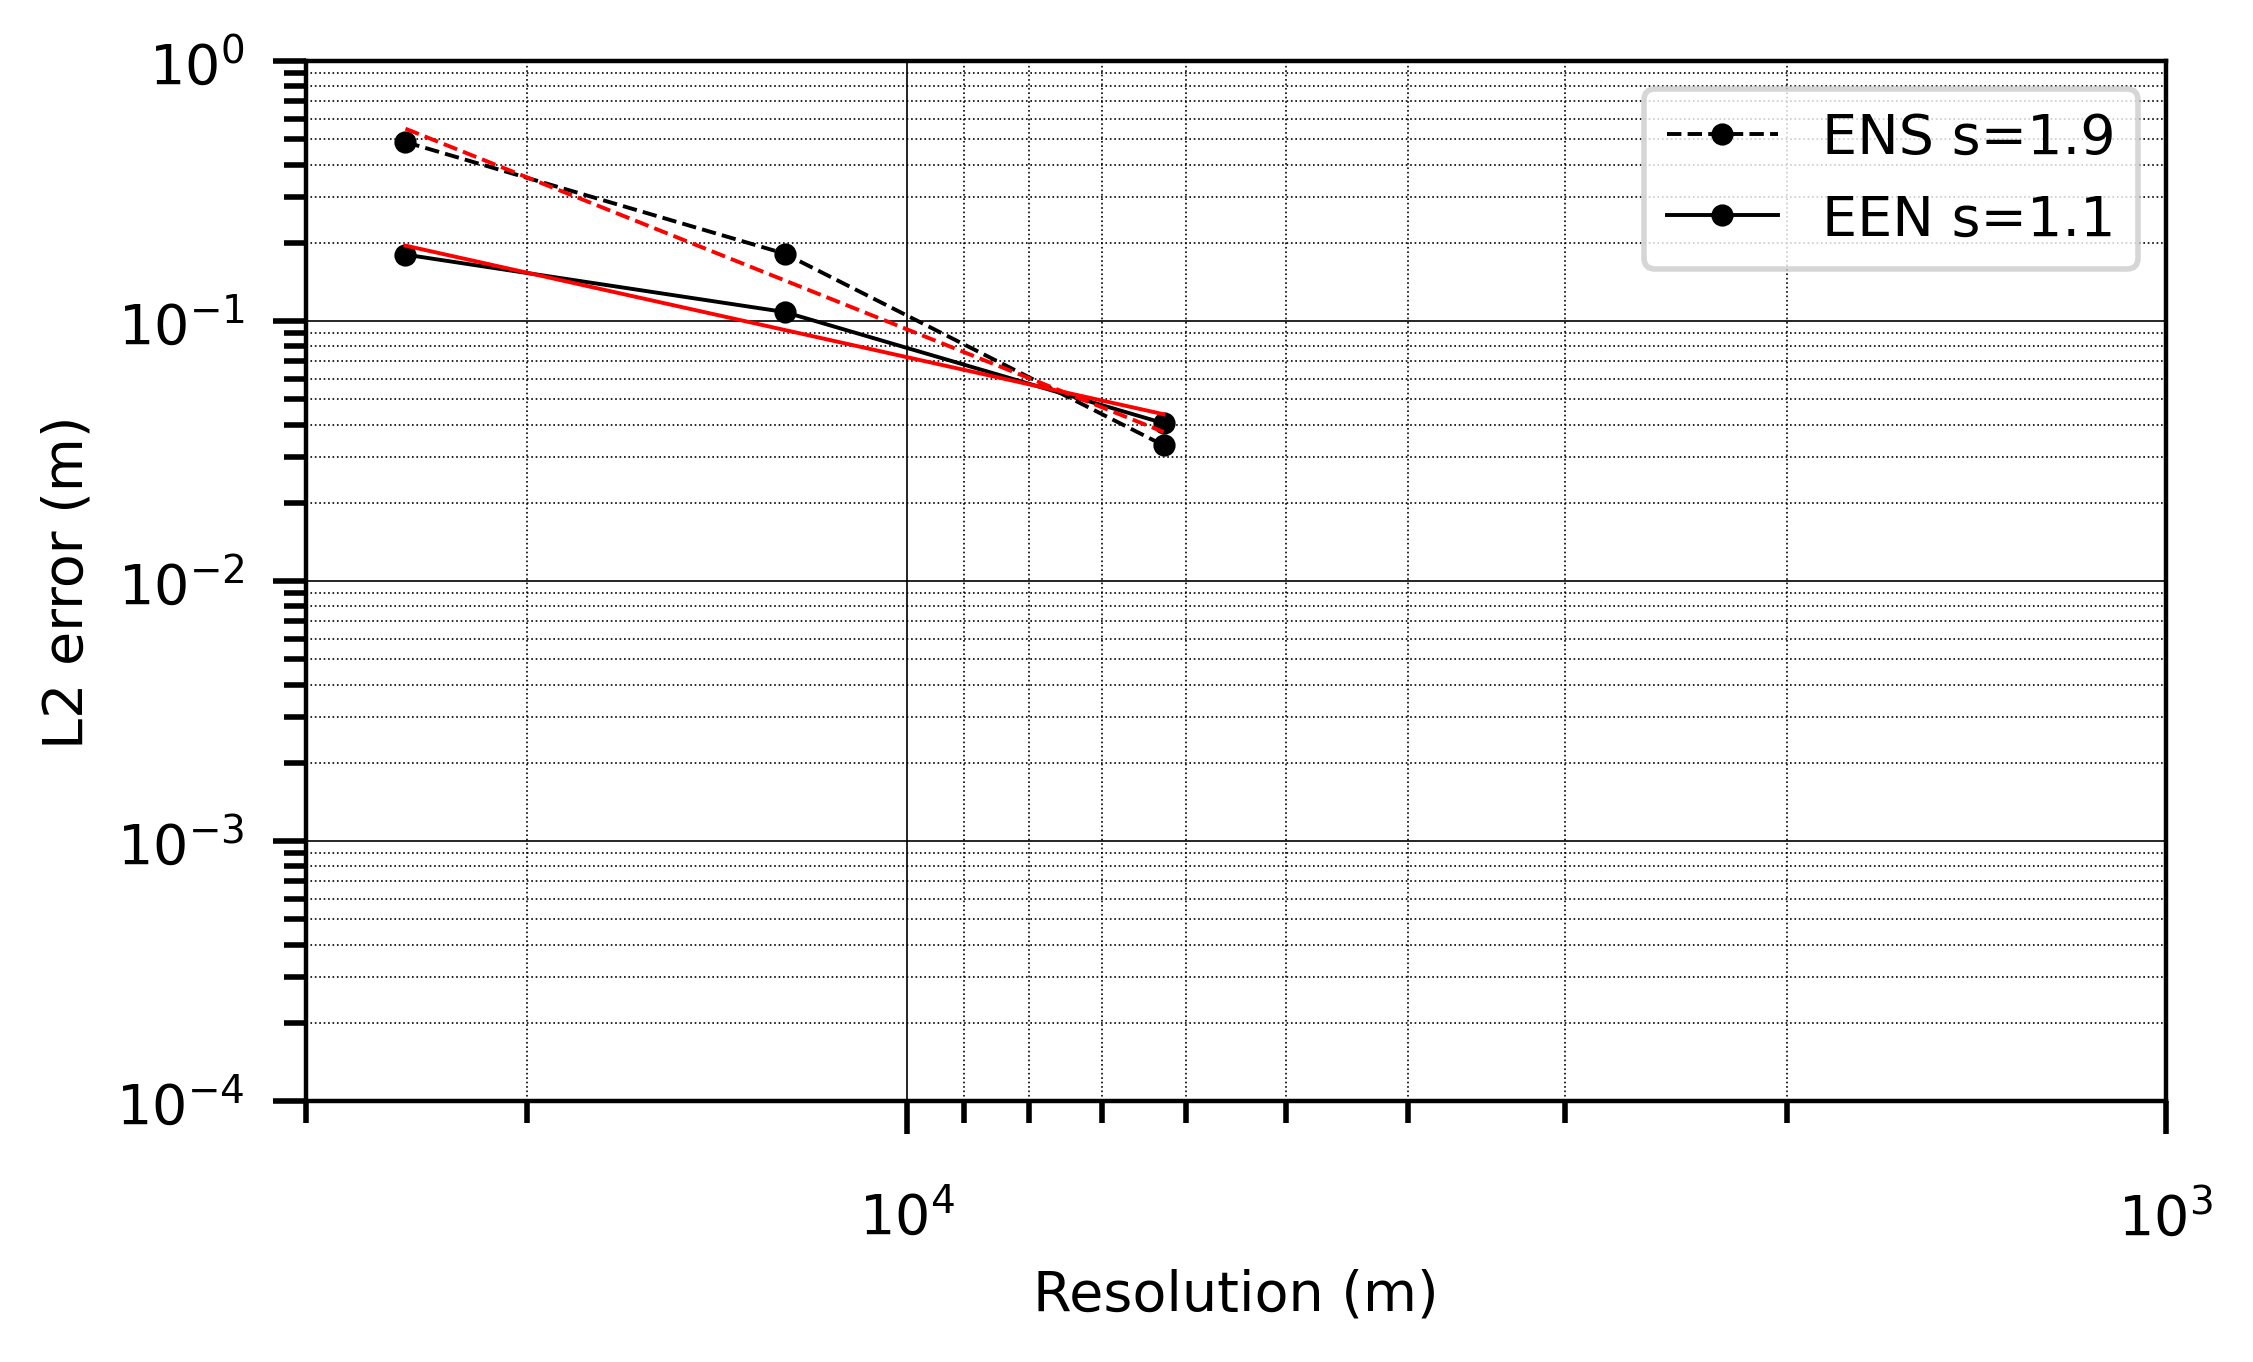

In [12]:
save = 0
fig, ax = plt.subplots(dpi=400)
ax.plot(xtic, nl2[0,:], linestyle = "--",
        marker="o", color="black", label = "ENS s=%1.1f" % (regr_ens.coef_),
        alpha=1., linewidth=.7, markersize=3.)

ax.plot(xtic, nl2[1,:], linestyle = "-",
        marker="o", color="black", label = "EEN s=%1.1f" % (regr_een.coef_),
        alpha=1., linewidth=.7, markersize=3.)

ax.plot(np.power(10,x), yp_ens, linestyle = "--",
        marker="o", color="red", label = "_no_legend_",
        alpha=1., linewidth=.7, markersize=0.)
ax.plot(np.power(10,x), yp_een, linestyle = "-",
        marker="o", color="red", label = "_no_legend_",
        alpha=1., linewidth=.7, markersize=0.)

ax.legend()
ax.set_yscale('log') # default is base 10
ax.set_ylim(1e-4,1e-0)
ax.set_xscale('log')
#ax.set_xticks(xtic)
#ax.set_xticklabels([])
#ax.set_xticklabels(xlab)
ax.set_xlim(3e4,1e3)

#ax3.xaxis.set_major_locator(mticker.MaxNLocator(3))
#ticks_loc = ax3.get_xticks().tolist()
#ax3.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
#ax3.set_xticklabels([label_format.format(x) for x in ticks_loc])

ax.grid(which='major', linestyle='-', linewidth='0.3', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
ax.tick_params(axis = "y", which = 'both', width=1., labelsize = 10, pad = 5)
ax.tick_params(axis = 'x', which = 'both', width=1., labelsize = 10, pad = 10)
ax.tick_params(which='minor',length = 4)
ax.tick_params(which='major',length = 6)
ax.set_ylabel("L2 error (m)")
ax.set_xlabel("Resolution (m)")
fig.subplots_adjust(top = 0.8, bottom=0.15, hspace = 0.02)

if save :
    print("saving : %s" % psave)
    fig.savefig(psave)
else :
    plt.show()

## Interpolation

In [5]:
from scipy import interpolate

res_ref = 4
nl2 = np.zeros((2,res_ref)) 

for vor in range(2):
    nn_ref,_,pdt_ref,pmm_ref = listpdt[vor][res_ref]
    dt_ref = nc4.Dataset(pdt_ref)
    mm_ref = nc4.Dataset(pmm_ref)
    tmask_ref = mm_ref.variables['tmask'][0,0]
    
    glamt_ref = dt_ref.variables['nav_lon']
    gphit_ref = dt_ref.variables['nav_lat']
    print("... dataframe : %s" % (pdt_ref))
    ssh = dt_ref.variables['sshmeaned'][-60:,:,:].copy() +500.
    #
    ssh_ref = np.mean(ssh[:,:,:], axis=0) 
    ni,nj=np.shape(ssh_ref)
    ssh_ref = ssh_ref * tmask_ref
    #
    fref = interpolate.interp2d(glamt_ref[0,:], gphit_ref[:,0], ssh_ref, kind='linear')
    
    for res in range(res_ref):
        nn_hd,_,pdt_hd,pmm_hd = listpdt[vor][res]
        dt_hd = nc4.Dataset(pdt_hd)
        mm_hd = nc4.Dataset(pmm_hd)
        tmask_hd = mm_hd.variables['tmask'][0,0]

        glamt_hd = dt_hd.variables['nav_lon']
        gphit_hd = dt_hd.variables['nav_lat']
        print("... dataframe : %s" % (pdt_hd))
        ssh = dt_hd.variables['sshmeaned'][-60:,:,:].copy() +500.
        #
        ssh_hd = np.mean(ssh[:,:,:], axis=0) 
        Nnodes = np.sum(tmask_hd)
        #Nnodes=1.
        ssh_hd = ssh_hd 
        #
        data = tmask_hd*(ssh_hd - fref(glamt_hd[0,:], gphit_hd[:,0]))
        nl2[vor,res]=np.sqrt(np.sum(data*data))/Nnodes
        
xlab = ["1/4°","1/8°","1/16°","1/32°","1/48°"]
xtic = np.array([100e3/4,100e3/8,100e3/16,100e3/32,100e3/48])
xtic = xtic[:res_ref]

... dataframe : /gpfswork/rech/bho/ukd13rj/nemo/dev_r12527_Gurvan_ShallowWater/cfgs/article_AM98/EXP_48_ens_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc
... dataframe : /gpfswork/rech/bho/ukd13rj/nemo/dev_r12527_Gurvan_ShallowWater/cfgs/article_AM98/EXP_4_ens_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc
... dataframe : /gpfswork/rech/bho/ukd13rj/nemo/dev_r12527_Gurvan_ShallowWater/cfgs/article_AM98/EXP_8_ens_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc
... dataframe : /gpfswork/rech/bho/ukd13rj/nemo/dev_r12527_Gurvan_ShallowWater/cfgs/article_AM98/EXP_16_ens_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc
... dataframe : /gpfswork/rech/bho/ukd13rj/nemo/dev_r12527_Gurvan_ShallowWater/cfgs/article_AM98/EXP_32_ens_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc
... dataframe : /gpfswork/rech/omr/ukd13rj/nemo/dev_r12527_Gurvan_ShallowWater/cfgs/article_AM98/EXP_48_een_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc
... dataframe : /gpfswork/rech/bho/ukd13rj/nemo/dev_r12527_Gurvan_ShallowWater/cfgs/articl

In [20]:
x = np.log10(xtic[:])
y_ens = np.log10(nl2[0,:])
y_een = np.log10(nl2[1,:])
print("slope ens",(y_ens[-1] - y_ens[0])/(x[-1] - x[0]))
print("slope een",(y_een[-1] - y_een[0])/(x[-1] - x[0]))

slope ens 3.1850740186586224
slope een 2.401358489840794


In [21]:
from sklearn.linear_model import LinearRegression

x = x.reshape((-1, 1))

#regr = linear_model.LinearRegression(fit_intercept=False)
regr_ens = LinearRegression().fit(x, y_ens)
regr_een = LinearRegression().fit(x, y_een)

print("ENS :")
#regr.fit(x,y)
print('coefficient of determination:', regr_ens.score(x, y_ens))
# Print the Slope:
print('slope:', regr_ens.coef_)

print("EEN :")
#regr.fit(x,y)
print('coefficient of determination:', regr_een.score(x, y_een))
# Print the Slope:
print('slope:', regr_een.coef_)

# Predict a Response and print it:
yp_ens = np.power(10,regr_ens.predict(x))
yp_een = np.power(10,regr_een.predict(x))

#yp_ens = np.power(10,regr_ens.coef_*(x-x[-1]) + y_ens[-1])
#yp_een = np.power(10,regr_een.coef_*(x-x[-1]) + y_een[-1])
#print('Predicted response:', y_pred, sep='\n')

ENS :
coefficient of determination: 0.9891174200240164
slope: [3.19416103]
EEN :
coefficient of determination: 0.9755307496495567
slope: [2.38336804]


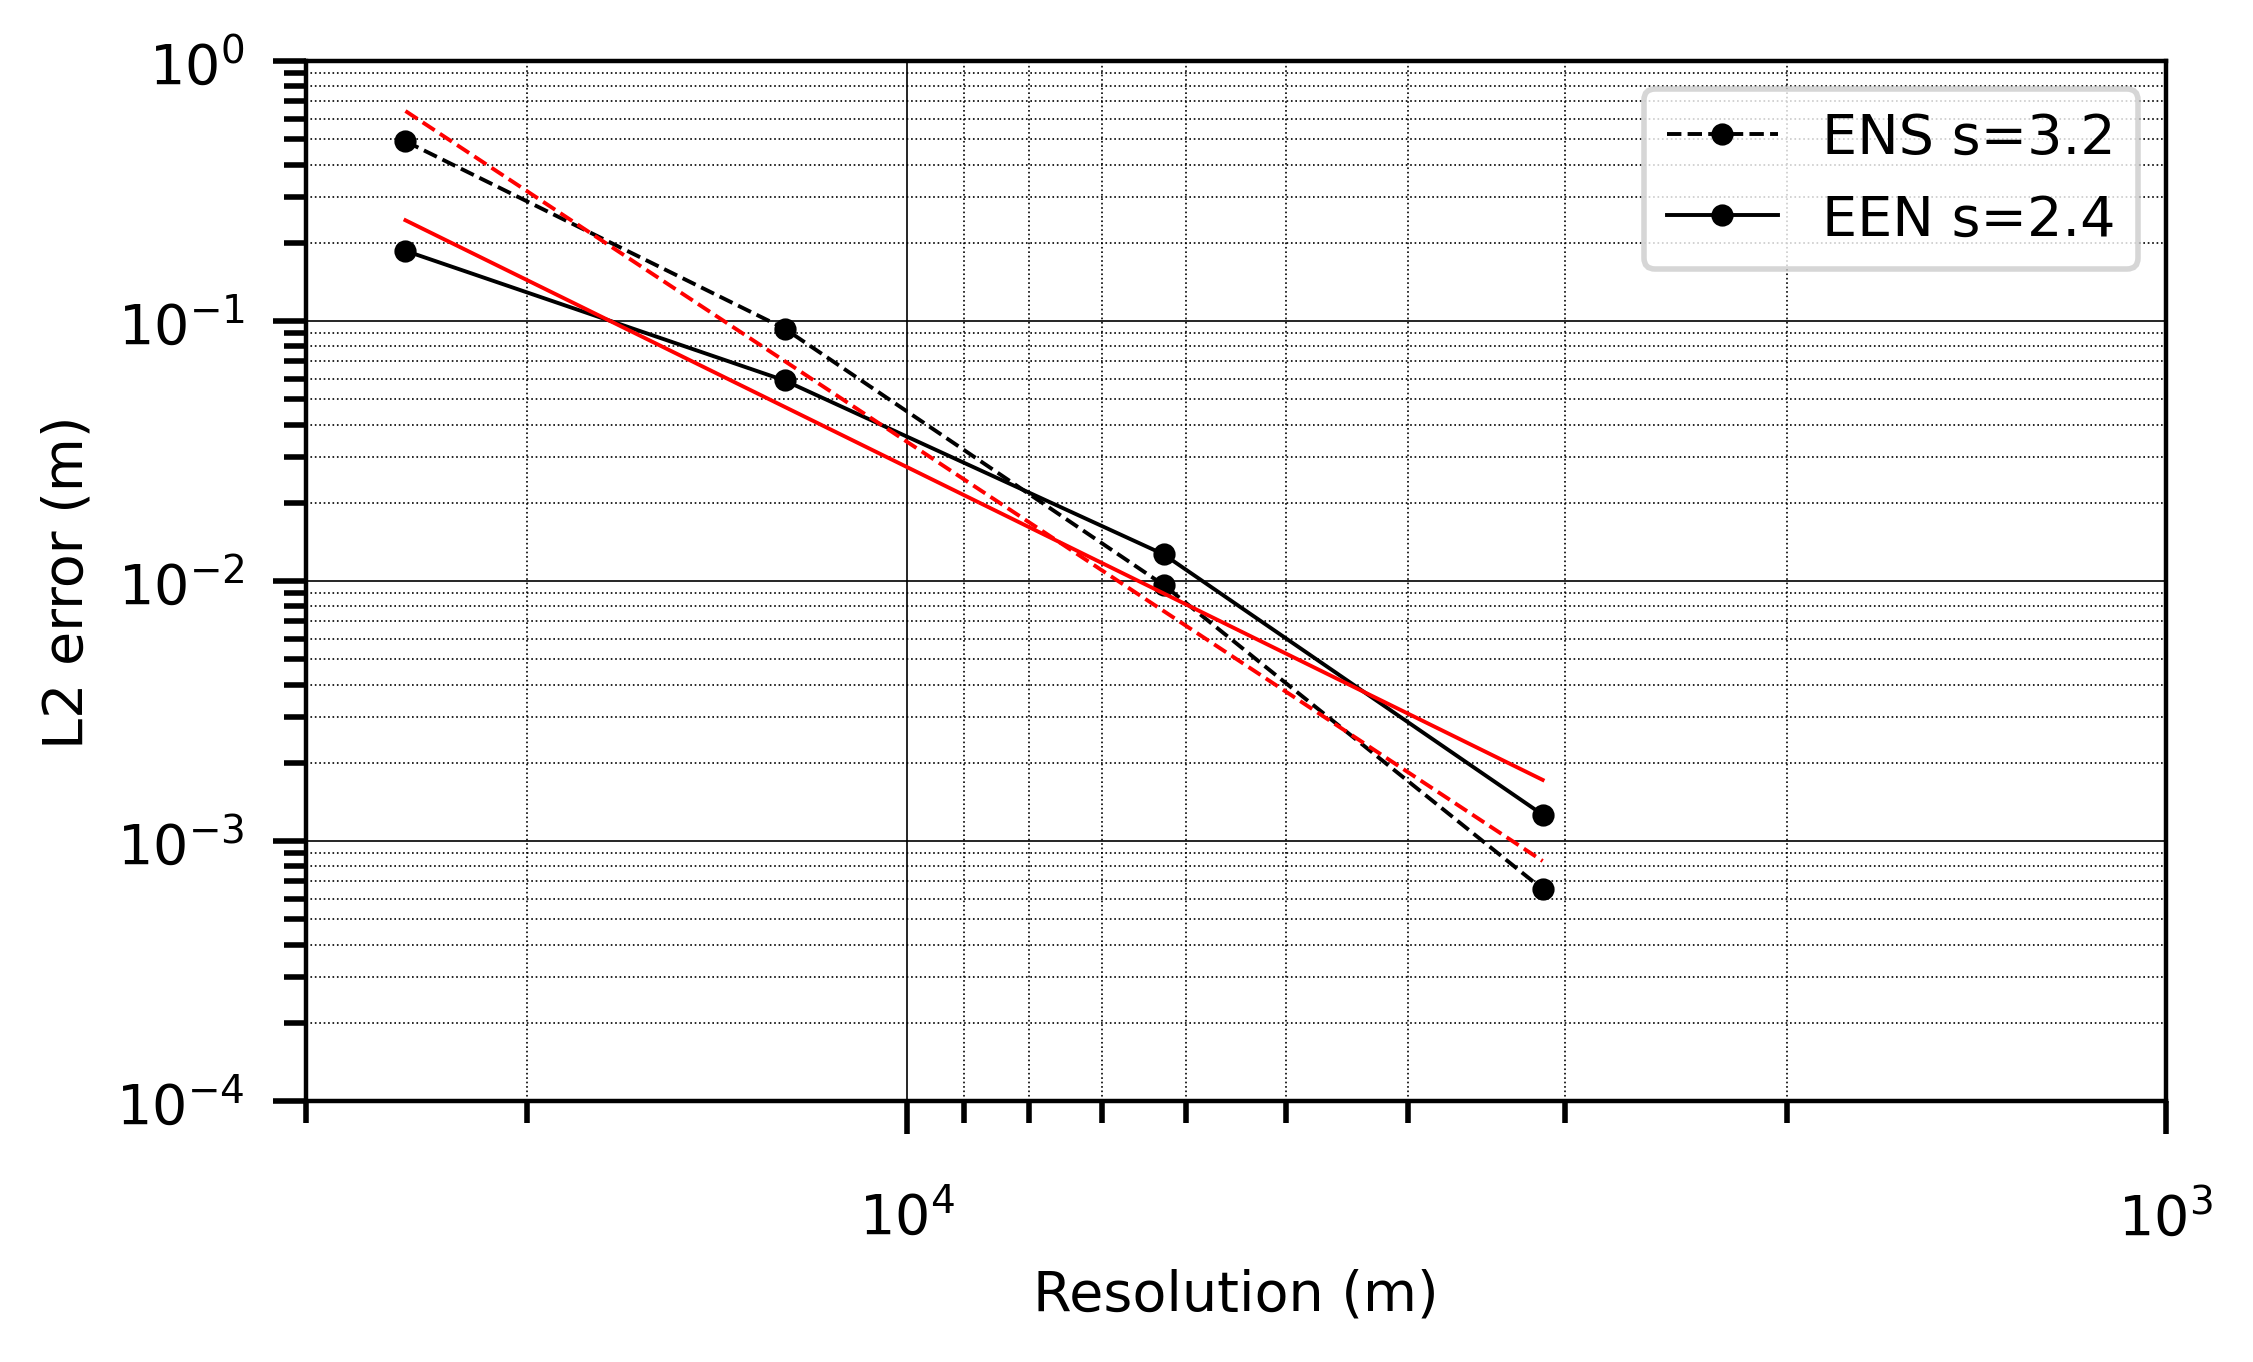

In [22]:
save = 0
fig, ax = plt.subplots(dpi=400)
ax.plot(xtic, nl2[0,:], linestyle = "--",
        marker="o", color="black", label = "ENS s=%1.1f" % (regr_ens.coef_),
        alpha=1., linewidth=.7, markersize=3.)

ax.plot(xtic, nl2[1,:], linestyle = "-",
        marker="o", color="black", label = "EEN s=%1.1f" % (regr_een.coef_),
        alpha=1., linewidth=.7, markersize=3.)

ax.plot(np.power(10,x), yp_ens, linestyle = "--",
        marker="o", color="red", label = "_no_legend_",
        alpha=1., linewidth=.7, markersize=0.)
ax.plot(np.power(10,x), yp_een, linestyle = "-",
        marker="o", color="red", label = "_no_legend_",
        alpha=1., linewidth=.7, markersize=0.)

ax.legend()
ax.set_yscale('log') # default is base 10
ax.set_ylim(1e-4,1e-0)
ax.set_xscale('log')
#ax.set_xticks(xtic)
#ax.set_xticklabels([])
#ax.set_xticklabels(xlab)
ax.set_xlim(3e4,1e3)

#ax3.xaxis.set_major_locator(mticker.MaxNLocator(3))
#ticks_loc = ax3.get_xticks().tolist()
#ax3.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
#ax3.set_xticklabels([label_format.format(x) for x in ticks_loc])

ax.grid(which='major', linestyle='-', linewidth='0.3', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
ax.tick_params(axis = "y", which = 'both', width=1., labelsize = 10, pad = 5)
ax.tick_params(axis = 'x', which = 'both', width=1., labelsize = 10, pad = 10)
ax.tick_params(which='minor',length = 4)
ax.tick_params(which='major',length = 6)
ax.set_ylabel("L2 error (m)")
ax.set_xlabel("Resolution (m)")
fig.subplots_adjust(top = 0.8, bottom=0.15, hspace = 0.02)

if save :
    print("saving : %s" % psave)
    fig.savefig(psave)
else :
    plt.show()

In [124]:
nl2

array([[0.49179759, 0.09363486, 0.00966674, 0.0006537 ],
       [0.18638533, 0.05914594, 0.01268238, 0.00126406]])

In [136]:
res = 4
nn_hd,_,pdt_hd,pmm_hd = listpdt[vor][res]
dt_hd = nc4.Dataset(pdt_hd)
mm_hd = nc4.Dataset(pmm_hd)
tmask_hd = mm_hd.variables['tmask'][0,0]
glamt_hd = dt_hd.variables['nav_lon']
gphit_hd = dt_hd.variables['nav_lat']
print("... dataframe : %s" % (pdt_hd))
ssh = dt_hd.variables['sshmeaned'][-60:,:,:].copy() +500.
#
ssh_hd = np.mean(ssh[:,:,:], axis=0) 
ni,nj=np.shape(ssh_hd)
Nnodes = np.sum(tmask_hd)
ssh_hd = ssh_hd * tmask_hd
#
data = tmask_hd*(ssh_hd - fref(glamt_hd[0,:], gphit_hd[:,0]))

... dataframe : /gpfswork/rech/omr/ukd13rj/nemo/dev_r12527_Gurvan_ShallowWater/cfgs/article_AM98/EXP_48_een_fs0_rot/AM98_1m_00010101_00251230_grid_T.nc


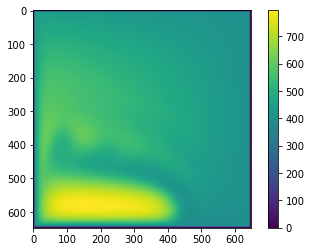

In [10]:
plt.imshow(fref(glamt_hd[0,:], gphit_hd[:,0]))
plt.colorbar()

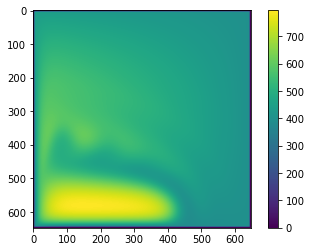

In [12]:
plt.imshow(tmask_hd * ssh_hd)
plt.colorbar()

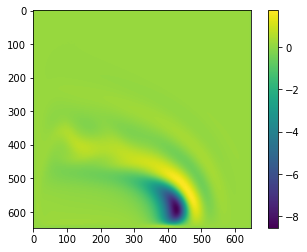

In [6]:
plt.imshow(data)
plt.colorbar()

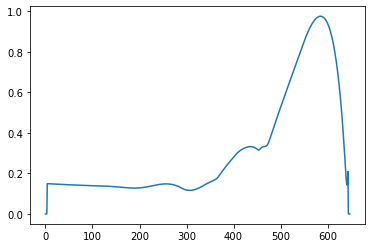

In [15]:
plt.plot(np.sum(np.abs(data),axis=1)/648)

In [7]:
np.shape(data)

(648, 648)

968